Questions:
1. pourquoi le nombre de couches augmente ? 32 > 64 comment décider ? 



In [41]:
# A mettre au début d'un colab pour enregistrer data sur le MyDrive
# # from google.colab import drive
# # drive.mount('/content/gdrive')

In [95]:
from keras.models import Sequential
from keras import backend as K 
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import h5py
import cv2
import numpy as np 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [43]:
def predict_label(img, model):
    img = cv2.imread(img)
    img = cv2.resize(img,(150,150))
    img = np.reshape(img,[1,150,150,3])
    classes = model.predict_classes(img)
    return labels[classes[0]]

In [44]:
# Rajout de parametres dropout,
def create_model(num_filters,num_filters1, kernel_size, dropout, optimizer):
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size, input_shape=(150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters1, kernel_size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(num_filters1, kernel_size))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
    metrics=['accuracy'])
    return model

In [45]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [46]:
#CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


In [47]:
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [48]:
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [49]:
# dense 
model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

N.B: optimier = 'rmsprop: 
Maintenir une moyenne mobile (actualisée) du carré des dégradés Divisez le gradient par la racine de cette moyenne

Data pre­processing and data augmentation
https://keras.io/api/preprocessing/image/

https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/


In [50]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [51]:
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')


In [52]:
img = load_img('../data/sample_data/train/cats/cat453a.jpg') # this is a PIL image
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
print(x.shape)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
print(x.shape)
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='../data/sample_data/preview',save_prefix='cat', save_format='jpeg'):
  i += 1
  if i > 20:
      break # otherwise the generator would loop indefinitely

(242, 242, 3)
(1, 242, 242, 3)


In [53]:
model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

In [54]:
batch_size = 16
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

In [55]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [56]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory('../data/sample_data/train', # this is the target directory
                                                    classes = ["cats","dogs"],
                                                    target_size=(150, 150), # all images will be resized to 150x150
                                                    batch_size=batch_size,
                                                    class_mode='binary') # since we use binary_crossentropy loss, we need binary labels

Found 487 images belonging to 2 classes.


In [57]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory('../data/sample_data/validation',
                                                        classes = ["cats","dogs"],
                                                        target_size=(150, 150),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

Found 31 images belonging to 2 classes.


In [58]:
history = model.fit(train_generator,
                    #steps_per_epoch= 2 , # // batch_size,
                    epochs=50,
                    verbose=True,
                    validation_data=validation_generator)
                    #validation_steps= 2 ) # // batch_size)
# model.save_weights('../data/sample_data/first_try.tf') # always save your weights after training or during training

Epoch 1/50
31/31 [==============================] - 5s 139ms/step - loss: 1.1157 - accuracy: 0.7862 - val_loss: 0.7634 - val_accuracy: 0.6129
Epoch 2/50
31/31 [==============================] - 4s 135ms/step - loss: 0.5441 - accuracy: 0.7869 - val_loss: 0.6341 - val_accuracy: 0.6129
Epoch 3/50
31/31 [==============================] - 4s 134ms/step - loss: 0.4916 - accuracy: 0.7976 - val_loss: 0.9640 - val_accuracy: 0.6129
Epoch 4/50
31/31 [==============================] - 5s 151ms/step - loss: 0.6025 - accuracy: 0.8257 - val_loss: 0.5902 - val_accuracy: 0.6452
Epoch 5/50
31/31 [==============================] - 5s 147ms/step - loss: 0.3308 - accuracy: 0.8446 - val_loss: 0.4552 - val_accuracy: 0.6452
Epoch 6/50
31/31 [==============================] - 5s 146ms/step - loss: 0.3907 - accuracy: 0.8367 - val_loss: 0.6385 - val_accuracy: 0.7097
Epoch 7/50
31/31 [==============================] - 5s 148ms/step - loss: 0.2179 - accuracy: 0.8857 - val_loss: 0.3294 - val_accuracy: 0.8387
Epoch 

In [59]:
# model.save_weights('../data/saved_weights/oui.h5') # always save your weights after training or during training
# model.load_weights('../data/saved_weights/oui.h5')  # load model weights

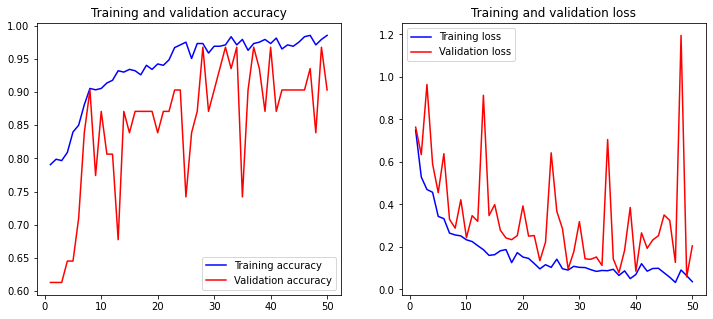

In [60]:
plot_history(history)

In [61]:
from __future__ import print_function

import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")

        print("  f.attrs.items(): ")
        for key, value in f.attrs.items():           
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            print("  Terminate # len(f.items())==0: ")
            return 

        print("  layer, g in f.items():")
        for layer, g in f.items():            
            print("  {}".format(layer))
            print("    g.attrs.items(): Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                print("    Dataset: param.keys():")
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()


In [62]:
# model = print_structure('../data/sample_data/first_try.h5')

In [63]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('../data/sample_data/ImageTest/DogHead/dog000001c.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
classes = model.predict(img)
print(classes)

[[1.]]


In [64]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1}

In [65]:
# Model m

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [66]:
batch_size = 16
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

In [67]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory('../data/sample_data/train', # this is the target directory
classes = ["cats","dogs","rabbits"],
target_size=(150, 150), # all images will be resized to 150x150
batch_size=batch_size)
#,class_mode='binary')

Found 507 images belonging to 3 classes.


In [69]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory('../data/sample_data/validation',
                                                        classes = ["cats","dogs","rabbits"],
                                                        target_size=(150, 150),
                                                        batch_size=batch_size)
                                                        #,class_mode='binary')

Found 51 images belonging to 3 classes.


In [70]:
history = model.fit(train_generator,
                    #steps_per_epoch= 2 , # // batch_size,
                    epochs=25,
                    validation_data=validation_generator,
                    #validation_steps= 2 
                    ) # // batch_size)
model.save_weights('../data/saved_weights/first_try.h5') # always save your weights after training or during training

Epoch 1/25
32/32 [==============================] - 5s 151ms/step - loss: 0.9320 - accuracy: 0.6737 - val_loss: 1.4176 - val_accuracy: 0.3725
Epoch 2/25
32/32 [==============================] - 5s 147ms/step - loss: 0.6834 - accuracy: 0.7449 - val_loss: 1.1614 - val_accuracy: 0.3725
Epoch 3/25
32/32 [==============================] - 5s 147ms/step - loss: 0.5927 - accuracy: 0.7798 - val_loss: 1.0976 - val_accuracy: 0.4510
Epoch 4/25
32/32 [==============================] - 5s 147ms/step - loss: 0.4367 - accuracy: 0.8235 - val_loss: 0.8160 - val_accuracy: 0.5098
Epoch 5/25
32/32 [==============================] - 5s 148ms/step - loss: 0.4001 - accuracy: 0.8516 - val_loss: 0.8287 - val_accuracy: 0.5098
Epoch 6/25
32/32 [==============================] - 5s 149ms/step - loss: 0.3721 - accuracy: 0.8701 - val_loss: 0.9113 - val_accuracy: 0.5098
Epoch 7/25
32/32 [==============================] - 5s 148ms/step - loss: 0.3219 - accuracy: 0.8886 - val_loss: 0.6322 - val_accuracy: 0.6078
Epoch 

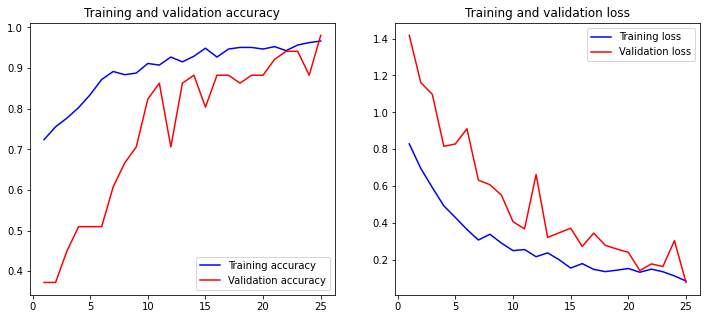

In [71]:
plot_history(history)

In [72]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1, 'rabbits': 2}

In [73]:

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('../data/sample_data/validation/dogs/dog000757a.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
classes = model.predict(img)
print(classes)
print(validation_generator.class_indices)

[[0. 1. 0.]]
{'cats': 0, 'dogs': 1, 'rabbits': 2}


In [74]:
# Model multiclasses

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [75]:
batch_size = 16
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

In [76]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory('../data/sample_data/validation',
                                                        classes = ["cats","dogs","rabbits"],
                                                        target_size=(150, 150),
                                                        batch_size=batch_size)
                                                        #,class_mode='binary')

Found 51 images belonging to 3 classes.


In [78]:
history = model.fit_generator(train_generator,
                            #steps_per_epoch= 2 , # // batch_size,
                            epochs=25,
                            validation_data=validation_generator,
                            #validation_steps= 2 
                            ) # // batch_size)
model.save_weights('../data/saved_weights/first_try.h5') # always save your weights after training or during training

/home/joshua/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/25
32/32 [==============================] - 5s 138ms/step - loss: 0.9393 - accuracy: 0.6344 - val_loss: 1.4067 - val_accuracy: 0.3725
Epoch 2/25
32/32 [==============================] - 4s 136ms/step - loss: 0.7602 - accuracy: 0.7491 - val_loss: 1.1747 - val_accuracy: 0.3725
Epoch 3/25
32/32 [==============================] - 4s 138ms/step - loss: 0.5640 - accuracy: 0.7770 - val_loss: 1.5263 - val_accuracy: 0.4510
Epoch 4/25
32/32 [==============================] - 5s 150ms/step - loss: 0.5128 - accuracy: 0.7932 - val_loss: 1.0029 - val_accuracy: 0.4314
Epoch 5/25
32/32 [==============================] - 5s 148ms/step - loss: 0.3976 - accuracy: 0.8185 - val_loss: 0.8411 - val_accurac

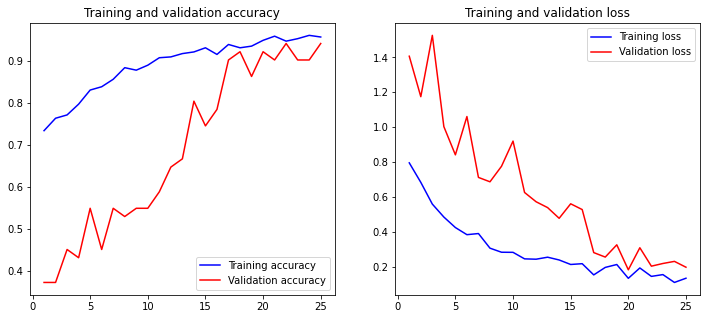

In [79]:
plot_history(history)

In [80]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1, 'rabbits': 2}

In [81]:
# img = load_img('../data/sample_data/ImageTest/nounou2.jpg') # this is a PIL image
# x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
# print(x.shape)
# x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
# print(x.shape)


img = cv2.imread('../data/sample_data/ImageTest/nounou2.jpg')
img = cv2.resize(img,(150,150))
img = np.reshape(img,[1,150,150,3])
classes = model.predict(img)
print(classes)

[[1. 0. 0.]]


In [82]:
validation_generator.class_indices

{'cats': 0, 'dogs': 1, 'rabbits': 2}

In [83]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [84]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [85]:
batch_size = 16
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [86]:
train_generator = train_datagen.flow_from_directory('../data/sample_data/train', # this is the target directory
                                                    classes = ["cats","dogs","rabbits"],
                                                    target_size=(150, 150), # all images will be resized to 150x150
                                                    batch_size=batch_size)
                                                    #,class_mode='binary')

Found 507 images belonging to 3 classes.


In [87]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory('../data/sample_data/validation',
                                                        classes = ["cats","dogs","rabbits"],
                                                        target_size=(150, 150),
                                                        batch_size=batch_size)
                                                        #,class_mode='binary')

Found 51 images belonging to 3 classes.


In [88]:
train_generator.class_indices
validation_generator.class_indices

{'cats': 0, 'dogs': 1, 'rabbits': 2}

In [89]:

#X_train, y_train = next(train_generator)
#X_test, y_test = next(validation_generator)

# ajoutée par Bassem
X_train, y_train = next(iter(train_generator))
X_test, y_test = next(iter(validation_generator))

In [90]:
print(X_test.shape)
print(y_test.shape)


(16, 150, 150, 3)
(16, 3)


In [91]:
param_grid = dict(num_filters=[16,32,64],
                  num_filters1= [64], 
                  kernel_size=[(3, 3)],
                  dropout = [0.3, 0.5],
                  optimizer =['RMSprop','Adam'])

In [96]:
K.clear_session()

epochs = 25

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=16,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test,y_test)
print('accuracy_test = ',test_accuracy)

print('best socre = ', grid_result.best_score_)
print('best param = ',grid_result.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
accuracy_test =  0.4375
best socre =  0.625
best param =  {'optimizer': 'Adam', 'num_filters1': 64, 'num_filters': 32, 'kernel_size': (3, 3), 'dropout': 0.5}


In [97]:
filenames = validation_generator.filenames
nb_samples = len(filenames)
nb_samples

51

In [98]:
model1 = create_model(optimizer= 'Adam', num_filters1= 64, num_filters= 32, kernel_size = (3, 3), dropout = 0.3)

In [99]:
K.clear_session()
history = model1.fit_generator(train_generator,
                                #steps_per_epoch= 2 , # // batch_size,
                                epochs=7,
                                validation_data=validation_generator,
                                #validation_steps= 2 
                                ) # // batch_size)
                                #model.save_weights('drive/MyDrive/sample_data/first_try.h5') # always save your weights after training or during training

/home/joshua/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/20
32/32 [==============================] - 6s 175ms/step - loss: 0.8572 - accuracy: 0.6923 - val_loss: 2.0007 - val_accuracy: 0.3725
Epoch 2/20
32/32 [==============================] - 5s 172ms/step - loss: 0.5943 - accuracy: 0.7887 - val_loss: 1.2396 - val_accuracy: 0.3725
Epoch 3/20
32/32 [==============================] - 6s 177ms/step - loss: 0.5623 - accuracy: 0.7813 - val_loss: 1.1071 - val_accuracy: 0.4706
Epoch 4/20
32/32 [==============================] - 6s 184ms/step - loss: 0.4311 - accuracy: 0.8041 - val_loss: 1.0689 - val_accuracy: 0.4706
Epoch 5/20
32/32 [==============================] - 6s 187ms/step - loss: 0.3886 - accuracy: 0.8416 - val_loss: 1.0313 - val_accurac

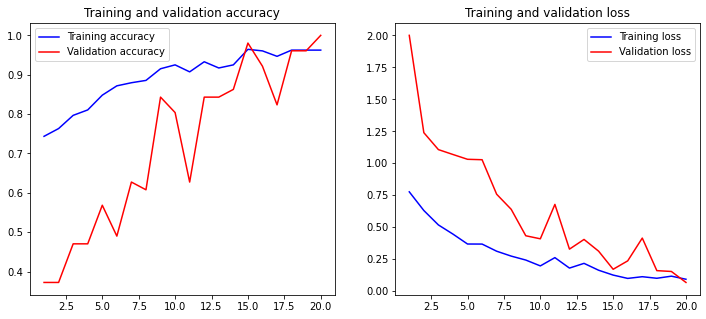

In [100]:
plot_history(history)

In [101]:
# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
    
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model1.predict_generator(validation_generator, nb_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['cat', 'dog', 'rabbit']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/home/joshua/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
Confusion Matrix
[[ 5  4  3]
 [ 2 10  7]
 [ 5  5 10]]
Classification Report
              precision    recall  f1-score   support

         cat       0.42      0.42      0.42        12
         dog       0.53      0.53      0.53        19
      rabbit       0.50      0.50      0.50        20

    accuracy                           0.49        51
   macro avg       0.48      0.48      0.48        51
weighted avg       0.49      0.49      0.49        51



In [102]:
print(validation_generator.class_indices)
labels = {v : k for k , v in train_generator.class_indices.items()}
print(labels)

{'cats': 0, 'dogs': 1, 'rabbits': 2}
{0: 'cats', 1: 'dogs', 2: 'rabbits'}


In [105]:

# Get list of animal in the folder
current_path = "../data/sample_data/ImageTest"
list_animal=[] 
for file in os.listdir(current_path):
  if file[0] != ".":
    list_animal.append(file)
print (list_animal)

['DogHead', 'rabbit1.jpeg', 'panda2.jpeg', 'panda1.jpeg', 'rabbit2.jpeg', 'nounou2.jpg']


In [107]:

plt.figure(figsize=(10, 10))
for i, image in enumerate(list_animal):
    ax = plt.subplot(4, 3, i +1)
    path =  "../data/sample_data/ImageTest/" + image
    
    y_pred = predict_label(path, model1)   
    img1 = load_img(path, target_size=(150, 150))
    plt.imshow(img1)
    label = "Predict :" + y_pred
    plt.title(label)
    plt.axis("off")

error: OpenCV(4.5.1) /tmp/pip-req-build-ms668fyv/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
